In [42]:
# importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import emoji
import re
import scipy.sparse

import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

lemmatizer = WordNetLemmatizer()  # initalizing lemmatizer function
pd.set_option('max_colwidth', 400)

# First, let's get a feel for the data.

In [2]:
df = pd.read_csv("RedditData.csv")
df.head(5)

,subreddit,body,controversiality,score
0,gameofthrones,"Your submission has been automatically removed because all post titles must begin with one hard-bracketed spoiler scope tag, like [SPOILERS] or [NO SPOILERS]. Please review the options posted in the [spoiler guide](/r/gameofthrones/w/spoiler_guide) to find the title scope most appropriate for your post and [resubmit your content](/r/gameofthrones/submit).\n\n*I am a bot, and this action was pe...",0,1
1,aww,"Dont squeeze her with you massive hand, you mean giant.",0,19
2,gaming,It's pretty well known and it was a paid product placement. Hamilton advertised the watch around the movie and had an Interstellar page on their website. The biggest product placement was the Carhartt jacket though. Brands send old merch all the time by the way for movies. Just watch Stranger Things for tons of examples of that. Eggos are prominently featured as Eleven's favorite food.,0,3
3,news,You know we have laws against that currently correct? Or are you just willfully ignorant of gun laws in the US.,0,10
4,politics,"Yes, there is a difference between gentle suppression and hard suppression. Neither are good things.",0,1


In [3]:
#number of rows and columns in dataset
df.shape

(1000000, 4)

In [4]:
#info about the dataset
df.info()
#shows if any part of the dataset is missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB


In [5]:
#no missing values.
#Check class distribution
print(df['controversiality'].value_counts()[0])
print(df['controversiality'].value_counts()[1])


970417
29583


In [6]:
#number of controversial comments per subreddit
#each subreddit has 25,000 comments. Divide by 25,000 to get percentage

subreddits = df['subreddit'].unique()
subredditControversialityDataFrame = pd.DataFrame(columns=['subreddit', 'total_controversial_comments'])
i=0
for r in subreddits:
    #print("Number of controversial comments in r/"+r+" :",len(df.loc[(df["subreddit"] == r) & (df["controversiality"] == 1)]))
    subredditControversialityDataFrame.loc[i] = ["r/"+r, len(df.loc[(df["subreddit"] == r) & (df["controversiality"] == 1)])] 
    i=i+1



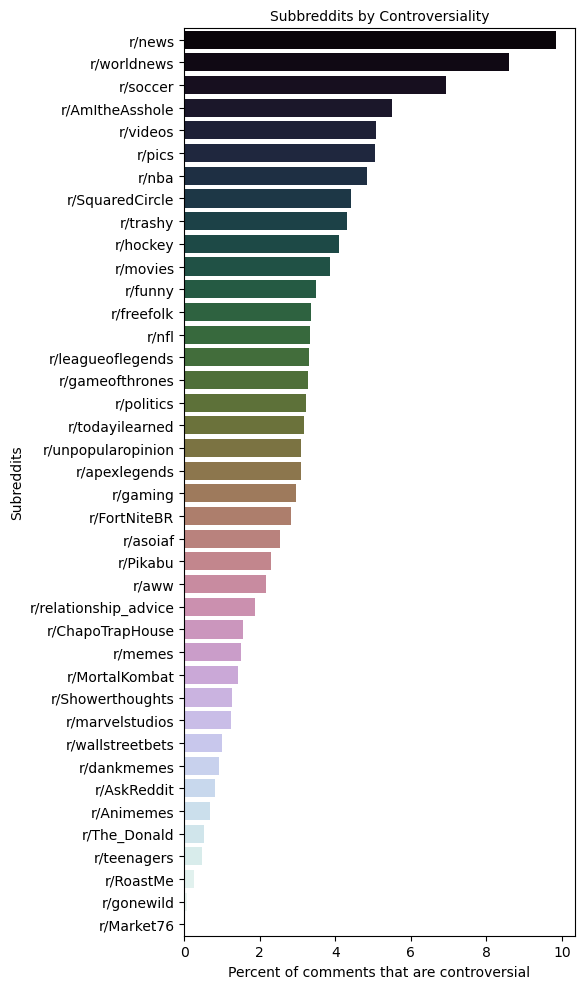

In [7]:
subredditControversialityDataFrame = subredditControversialityDataFrame.sort_values(by=["total_controversial_comments"], ascending=False)
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
ax = sns.barplot(data = subredditControversialityDataFrame, y=subredditControversialityDataFrame.subreddit, x = (subredditControversialityDataFrame.total_controversial_comments)/250, palette = "cubehelix")
plt.title("Subbreddits by Controversiality", fontsize = 10)
plt.ylabel('Subreddits', fontsize= 10)
plt.xlabel('Percent of comments that are controversial', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

# Clean the data

In [8]:
#Now we are building a comment classifier that checks for controversiality based on its content, subreddit, and score

#first drop any duplicates in the so it does not skew the model

print(df["body"].duplicated().sum())
df.drop_duplicates("body", inplace=True)

28271


In [9]:
#remove comments from bots
df = df[df["body"].str.contains("This is a bot|I am a bot|Thanks for posting to|your submission has been removed") == False]

#remove the only non-english sub-reddit to avoid non-english text ruining our classifiers
df = df[df['subreddit'] != 'Pikabu']

# Drop the lines with 0 controversiality and 0 score
df = df[~((df['controversiality'] == 0) & (df['score'] == 0))]

In [10]:
#Do data preprocessing
def remove_emoji(string): # function to remove emojis
    return emoji.replace_emoji(string, '')

df['body'] = df['body'].apply(remove_emoji) # removing emojis
df['body'] = df['body'].apply(lambda x:re.sub(r'((www.[^s]+)|(http\S+))', ' ', x)) # remove URLS
df['body'] = df['body'].str.replace("[\d_]", ' ',regex = True) # removes digits and underscore (_)
df['body'] = df['body'].str.lower() # lowering all characters
df['body'] = df['body'].str.replace('[^\w\s]', '',regex = True) # remove special characters
df['body'] = df['body'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) # remove single characters
df['body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(x,pos="v") for x in x.split()])) # lemmatizing




In [11]:
stop = stopwords.words('english')
stop.extend(['im','rt'])
df['body'] = df['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# See what words and phrases are common in controversial comments

In [12]:
empty_string = ''.join(df[df.controversiality == 1].body.values)

(-0.5, 1499.5, 999.5, -0.5)

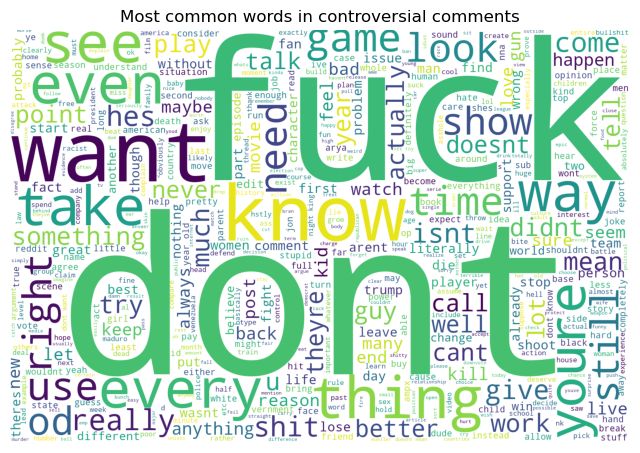

In [13]:
plt.figure(figsize=(8,8))
wc = WordCloud(background_color="white", max_words=500, width=1500, height=1000)


restricted = ["say","think","make","people","thats","im", "go", "one"]

for word in empty_string.split():
    if(word in restricted):
        empty_string = empty_string.replace(word, '')
        
wc.generate(empty_string)



        
plt.imshow(wc)
plt.title('Most common words in controversial comments')
plt.axis('off')

In [14]:
#make n-grams, 2&3  etc to see what kind of phrases make it controversial
#This cell takes 10ish minutes to run

#top ten bi-grams
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df[df.controversiality == 1].body.values)
frequencies = sum(sparse_matrix).toarray()[0]
top_bigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]


#top ten tri-grams
word_vectorizer = CountVectorizer(ngram_range=(3,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df[df.controversiality == 1].body.values)
frequencies = sum(sparse_matrix).toarray()[0]
top_trigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]



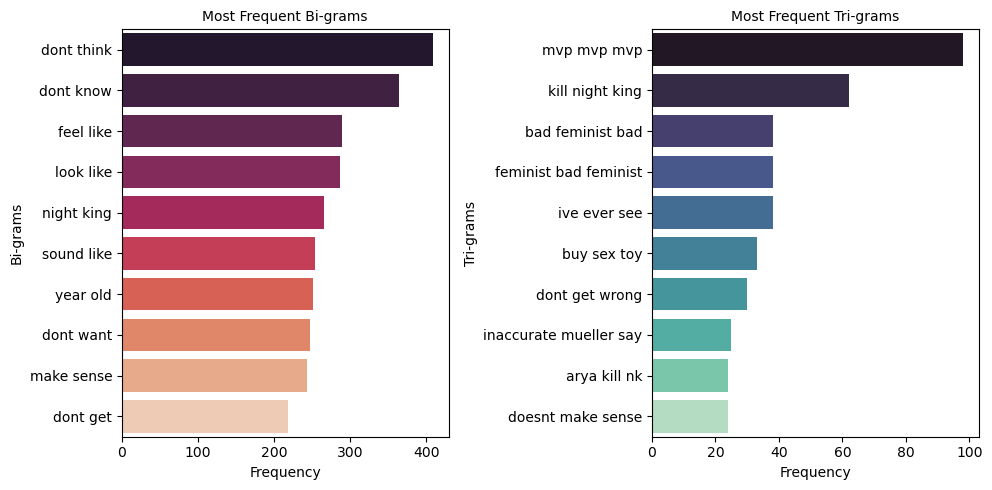

In [15]:
#plot the 10 most frequent bi-grams and tri-grams
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sns.barplot(data = top_bigrams, y=top_bigrams.index, x = top_bigrams.frequency, palette = "rocket")
plt.title("Most Frequent Bi-grams", fontsize = 10)
plt.ylabel('Bi-grams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()


plt.subplot(1,2,2)
ax = sns.barplot(data = top_trigrams, y=top_trigrams.index, x = top_trigrams.frequency, palette = "mako")
plt.title("Most Frequent Tri-grams", fontsize = 10)
plt.ylabel('Tri-grams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

## Build a comment classifier based on content, subreddit, and score

In [16]:
# Calculate TF-IDF
tv=TfidfVectorizer(max_features = 5000)
tv_df = tv.fit_transform(df['body'])


In [17]:
X = tv_df
Y = df['controversiality']

In [18]:
#append subreddit name and score to tv-idf sparse matrix

    
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'subreddit'
df['subreddit']= label_encoder.fit_transform(df['subreddit'])
df['subreddit'].unique()

array([13, 18, 26, 29, 14, 30, 25, 38,  2,  0,  9, 10, 17, 21, 20, 36, 32,
       19, 24, 16, 28, 22, 23, 31, 15,  6, 33, 11, 12,  5,  1,  4, 27, 34,
       35,  3,  7,  8, 37])

In [19]:
for_np = []

for (x,y) in zip(df['subreddit'],df['score']):
    row = []
    row.append(x)
    row.append(y)
    for_np.append(row)

n = np.array(for_np)
X = scipy.sparse.hstack([X, n])



# Logistic Regression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 50, stratify=Y)

In [21]:
#logistic regression

lr_cl = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_cl.fit(X_train, y_train)

lr_pred = lr_cl.predict(X_test)

In [22]:
print('Classification Report for Logistic Regression:\n',classification_report(y_test, lr_pred))

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    218955
           1       0.02      0.00      0.00      7207

    accuracy                           0.97    226162
   macro avg       0.50      0.50      0.49    226162
weighted avg       0.94      0.97      0.95    226162



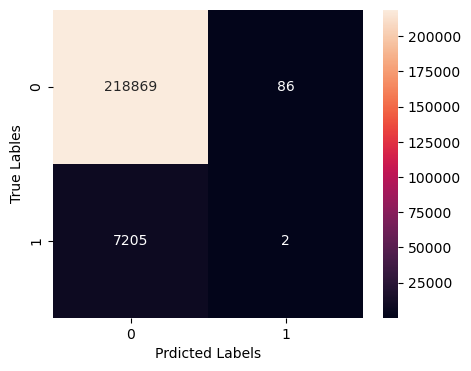

In [23]:
plt.figure(figsize=(5,4))
cm_labels = np.unique(y_test)
cm = confusion_matrix(y_test, lr_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show();

# Random Forest Classifier - Initial Run

In [24]:
#This cell will take over one hour
rf_cl = RandomForestClassifier(random_state = 50)
rf_cl.fit(X_train, y_train)

rf_pred = rf_cl.predict(X_test)

In [25]:
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    218955
           1       0.93      0.20      0.33      7207

    accuracy                           0.97    226162
   macro avg       0.95      0.60      0.66    226162
weighted avg       0.97      0.97      0.97    226162



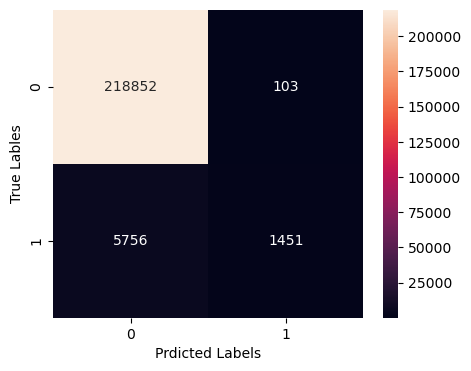

In [26]:
plt.figure(figsize=(5,4))
cm_labels = np.unique(y_test)
cm = confusion_matrix(y_test, rf_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show();

# Logistic Regression Classifier - Using Only the Score

In [27]:
X_S = df['score'].to_numpy()
Y_S = df['controversiality'].to_numpy()
X_S = X_S.reshape(-1, 1)



In [28]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_S, Y_S, test_size = 0.25, random_state = 50, stratify=Y_S)


In [29]:
#logistic regression
lr_cl2 = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_cl2.fit(X_train_S, y_train_S)

lr_pred2 = lr_cl2.predict(X_test_S)




In [30]:
print('Classification Report for Random Forest:\n',classification_report(y_test_S, lr_pred2))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    218955
           1       0.01      0.00      0.00      7207

    accuracy                           0.97    226162
   macro avg       0.49      0.50      0.49    226162
weighted avg       0.94      0.97      0.95    226162



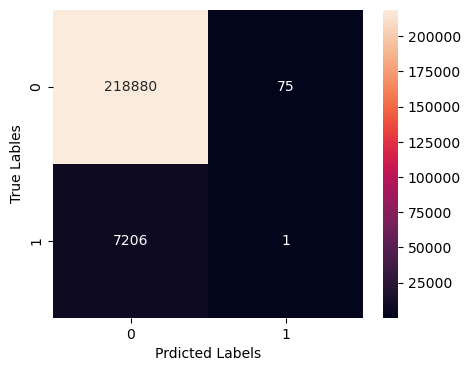

In [31]:
plt.figure(figsize=(5,4))
cm_labels = np.unique(y_test_S)
cm = confusion_matrix(y_test_S, lr_pred2)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show();

# Balancing the Data

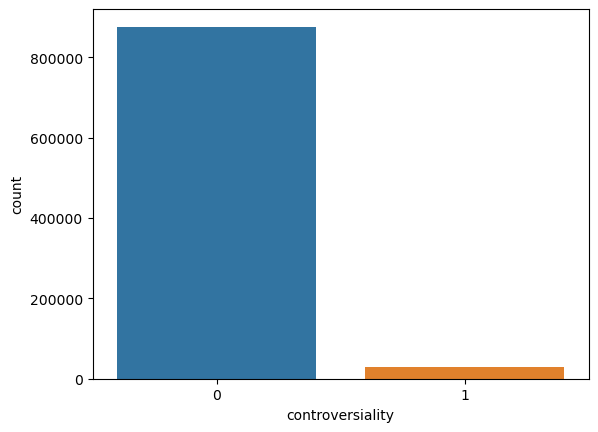

In [32]:
# data is very unbalanced

sns.countplot(x="controversiality", data=df)
plt.show()

In [33]:
#try balancing data by undersampling the non-controversial posts

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
rus.fit(X, Y)

X_us, y_us = rus.fit_resample(X, Y)


print(f'''Change of X before and after: {X.shape} -> {X_us.shape}''')
print("\nPositive and negative samples (%):")
y_us.value_counts(normalize=True)*100

Change of X before and after: (904646, 5002) -> (57652, 5002)

Positive and negative samples (%):


0    50.0
1    50.0
Name: controversiality, dtype: float64

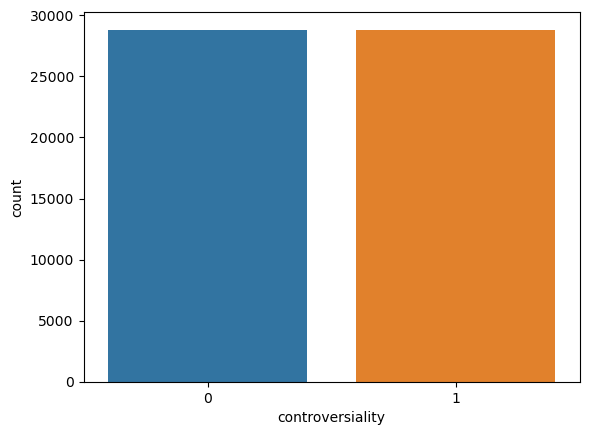

In [34]:
sns.countplot(x=y_us)
plt.show()

In [35]:
# now that the data is balanced, we can retrain and test with the RandomForest classifier model

X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size = 0.25, random_state = 50)

rf_cl3 = RandomForestClassifier(random_state = 50)
rf_cl3.fit(X_train, y_train)

rf_pred3 = rf_cl3.predict(X_test)

In [36]:
# Restesting the model to see accuracy

print('Classification Report for Random Forest with balanced data:\n', classification_report(y_test, rf_pred3))

Classification Report for Random Forest with balanced data:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78      7146
           1       0.81      0.72      0.76      7267

    accuracy                           0.77     14413
   macro avg       0.78      0.77      0.77     14413
weighted avg       0.78      0.77      0.77     14413



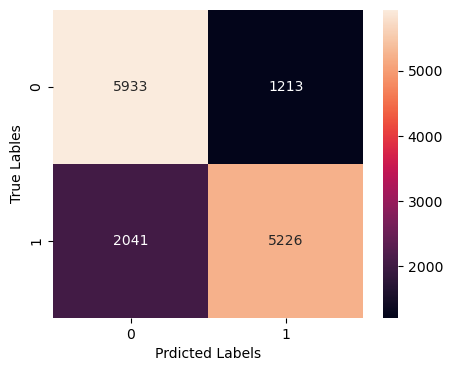

In [37]:
plt.figure(figsize=(5,4))
cm_labels = np.unique(y_test)
cm = confusion_matrix(y_test, rf_pred3)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show();

# Testing Random Forest Classifier (Trained with Balanced Data) on the Full Set

In [38]:
# Now we can test our classifier on the data

predict_full_Y = rf_cl3.predict(X)

print('Classification Report for Trained Random Forest Classifier on Data:\n', classification_report(predict_full_Y, Y))

Classification Report for Trained Random Forest Classifier on Data:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91    727896
           1       0.93      0.15      0.26    176750

    accuracy                           0.83    904646
   macro avg       0.88      0.57      0.58    904646
weighted avg       0.85      0.83      0.78    904646



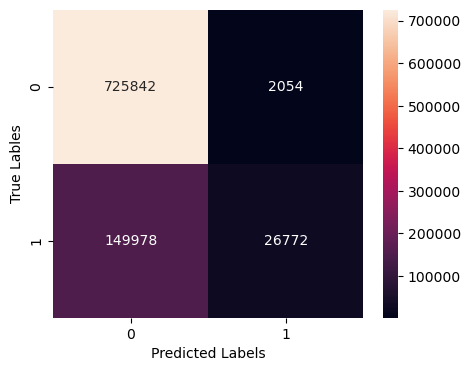

In [39]:
plt.figure(figsize=(5,4))
cm_labels = np.unique(predict_full_Y)
cm = confusion_matrix(predict_full_Y, Y)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Lables')

plt.show();

In [40]:
importances = rf_cl3.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_cl3.estimators_], axis=0)

len(importances)

5002